<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Deep-Learning/fashion_mnist_classification/Fashion_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import keras
import scipy.ndimage
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Conv2D, Activation, AveragePooling2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model, Sequential
from keras.utils import to_categorical
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import ReduceLROnPlateau
import gc

Importing the data

From Google Drive

In [ ]:
# importing google drive as we have uploaded the data to it
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
# Specifing the project path on google drive
#proj_path = '/content/gdrive/MyDrive/fashion-mnist/'

# Load the data into a DataFrame
#train_data = pd.read_csv(proj_path + 'fashion-mnist_train.csv') # reading the training dataset file
#test_data = pd.read_csv(proj_path + 'fashion-mnist_test.csv') # reading the testing dataset file

As noticed Keras has the Fashion MNIST data set so we imported it from Keras for easier reproducability of notebook.

In [ ]:
# Dataset
# https://keras.io/api/datasets/fashion_mnist/
from keras.datasets import fashion_mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print("Training data shape",x_train.shape,)
print("Training label Shape",y_train.shape, "\n")
print("Testing data shape",x_test.shape,)
print("Testing label Shape",y_test.shape)

Training data shape (60000, 28, 28)
Training label Shape (60000,) 

Testing data shape (10000, 28, 28)
Testing label Shape (10000,)


In [ ]:
np.bincount(y_train)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

<BarContainer object of 10 artists>

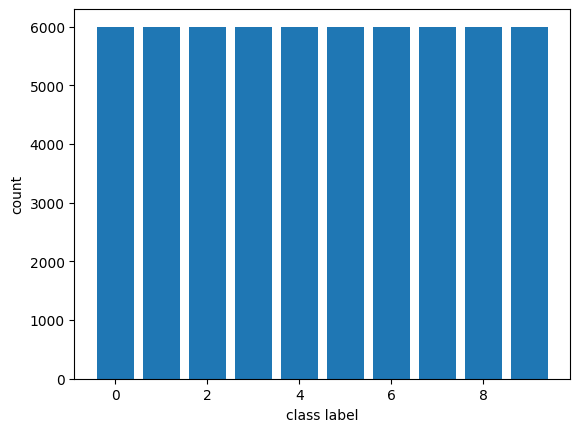

In [ ]:
plt.xlabel('class label')
plt.ylabel('count')
plt.bar(np.arange(0, len(np.bincount(y_train))), np.bincount(y_train))

Images Visualization

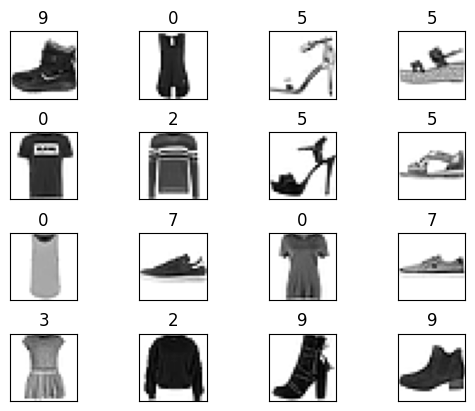

In [ ]:
N=4 # N**2 is number of images to plot
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(x_train[idx], cmap='binary')
    fig.subplots_adjust(hspace=0.5)
    y_target = y_train[idx]
    axes[row,col].set_title(y_target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
plt.show()
#print('\nShape BEFORE Lambda function: {}'.format(x_train[:32, ...].shape))
#print('Shape AFTER Lambda function: {}'.format(x_train_resized.shape))

# Normalization and reshaping for the input images

In [ ]:
num_classes = len(np.unique(y_train)) # 10

# Normalize and reshape the input images
x_train = np.expand_dims(x_train.astype('float32'), -1) # -1 means add the dimension from the end to be 60000x28x28x1
x_test = np.expand_dims(x_test.astype('float32'), -1)

x_train /= 255.0
x_test /= 255.0

# one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [ ]:
print('Training image shape after reshaping: {0}'.format(x_train.shape))
print('Testing image shape after reshaping: {0}'.format(x_test.shape))

print('Total number of training samples: {0}'.format(x_train.shape[0]))
print('Total number of test samples: {0}'.format(x_test.shape[0]))

Training image shape after reshaping: (60000, 28, 28, 1)
Testing image shape after reshaping: (10000, 28, 28, 1)
Total number of training samples: 60000
Total number of test samples: 10000


Splitting the training dataset into training and validation sets

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
print('Total number of training samples: {0}'.format(x_tr.shape[0]))
print('Total number of validation samples: {0}'.format(x_val.shape[0]))

Total number of training samples: 48000
Total number of validation samples: 12000


# Original LeNet-5 Architecture Model


*   *The first implementation in this section is without hyperparameters tuning, in the next section we will introduce the hyperparameters tuning using keras tuner.*
*   refrences: [Source 1](https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/), [Source 2](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)




In [ ]:

model = Sequential()

# Resize input image to be 32x32 to be same as the model design
model.add(Lambda(lambda x: tf.compat.v1.image.resize_images(x, (32, 32)), input_shape=(28,28,1)))

# 1st Convolutional Layer
model.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid')) # C1
model.add(Activation('tanh'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # S2

# 2nd Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid')) # C3
model.add(Activation('tanh'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # S4

# 3rd Convolutional Layer
model.add(Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), padding='valid')) # C5
model.add(Activation('tanh'))

# Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(units = 84,activation = 'tanh')) # F6

# 2nd Fully Connected Layer
model.add(Dense(units = 10, activation = 'softmax')) # output layer


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                        

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(123)

In [ ]:
%%time

# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=2,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.01,
                                min_lr=1e-6)

history = model.fit(x_tr, y_tr,
                    validation_data = (x_val, y_val),
                    batch_size = 32,
                    epochs = 50,
                    callbacks=[earlystop_callback, lr_reduction])

Epoch 1/50
1500/1500 [==============================] - 41s 26ms/step - loss: 0.5531 - accuracy: 0.7978 - val_loss: 0.4462 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 40s 26ms/step - loss: 0.4004 - accuracy: 0.8535 - val_loss: 0.3999 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 38s 26ms/step - loss: 0.3527 - accuracy: 0.8705 - val_loss: 0.3486 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 38s 25ms/step - loss: 0.3210 - accuracy: 0.8817 - val_loss: 0.3365 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 38s 26ms/step - loss: 0.2986 - accuracy: 0.8903 - val_loss: 0.3256 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 6/50
1500/1500 [==============================] - 38s 25ms/step - loss: 0.2762 - accuracy: 0.8970 - val_loss: 0.3161 - val_accuracy: 0.8844 - lr: 0.0010
Epoch 7/50
1500/1500 [========================

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.3110 - accuracy: 0.8919
Test loss: 0.3109826147556305
Test accuracy: 0.8919000029563904


Model history "metrics" plotting function

In [ ]:
def model_history_plot(history):

    tr_accuracy= history.history['accuracy']
    val_accuracy= history.history['val_accuracy']

    tr_loss= history.history['loss']
    val_loss= history.history['val_loss']

    learning_rate = history.history['lr']

    epochs = len(tr_accuracy)+1

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=1)

    ax2 = fig.add_subplot(131)
    plt.title(f"Training and Validation Accuracy VS Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1, epochs), val_accuracy, label="validation accuracy")
    plt.plot(np.arange(1,epochs), tr_accuracy, label = "training accuracy")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")

    ax2_t = ax2.twinx()
    ax2_t.plot(np.arange(1,epochs), learning_rate, 'o:r', label = "lr", alpha=0.2)
    plt.ylabel('Learning Rate')
    plt.legend(bbox_to_anchor=(1.2, 0.85), loc="upper left")

    ax1 = fig.add_subplot(132)
    plt.title(f"Training and Validation Loss VS Epochs")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(np.arange(1,epochs), val_loss, label="validation loss")
    plt.plot(np.arange(1,epochs), tr_loss, label = "training loss")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()

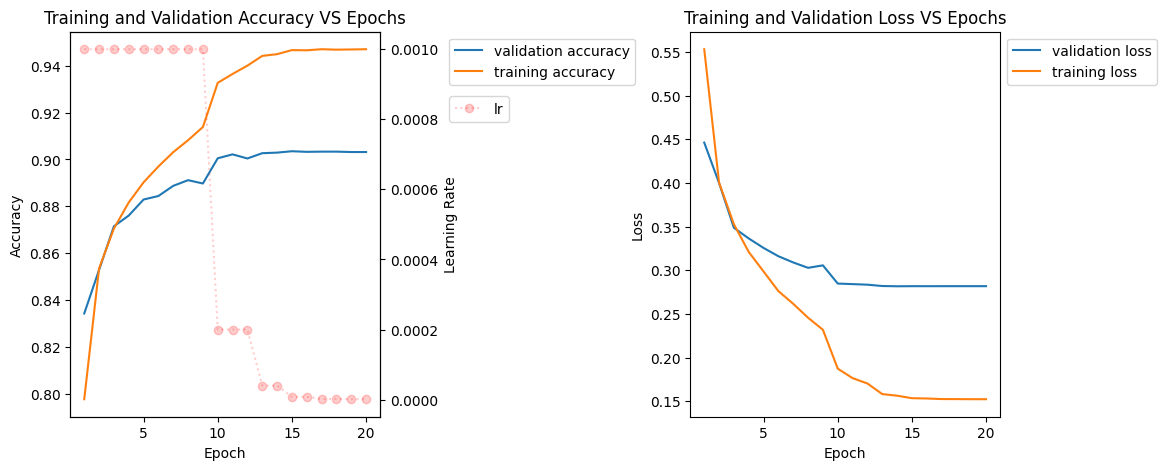

In [ ]:
model_history_plot(history)

# LeNet-5 Hyperparameters Tuning for the First Fully Connected Layer
In this section we are tuning the hyperparameters of LeNet5 model first fully connected layer. specifically we are tuning the following
* The number of units
* Activation Function
* Learning Rate
* Batch Size
* Weight Decay
* Dropout

Install and import the Keras Tuner and Tensorflow Addons.

In [ ]:
# keras tuner for hyperparameters search
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 5.6 MB/s eta 0:00:00


In [ ]:
# tensorflow addon for Adam optimizer enabling weight decay tuning
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
#keras.backend.clear_session()  #Clear the session to remove weights

class MyLenetHyperModel(kt.HyperModel): # inheriting from the HyperModel base class
    def build(self, hp):
        model = Sequential()

        # Resize input image to be 32x32 to be same as the model design
        model.add(Lambda(lambda x: tf.compat.v1.image.resize_images(x, (32, 32)), input_shape=(28,28,1)))

        # 1st Convolutional Layer
        model.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid')) # C1
        model.add(Activation('tanh'))
        model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # S2

        # 2nd Convolutional Layer
        model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid')) # C3
        model.add(Activation('tanh'))
        model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')) # S4

        # 3rd Convolutional Layer
        model.add(Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), padding='valid')) # C5
        model.add(Activation('tanh'))

        # Passing it to a Fully Connected layer
        model.add(Flatten())

        #-------------------------------------Fully Connected Layer Tuning-------------------------------------------#

        # 1st Fully Connected Layer
        model.add(Dense(
                units = hp.Int("hidden-units", min_value=60, max_value=120, step=10), # tunes number of hidden units.
                activation = hp.Choice("activation", values = ["tanh", "sigmoid", "softsign"])) # tunes the activation function
        )

        # Tune whether to use dropout and tune its rate
        model.add(Dropout(rate = hp.Float("dropout-rate", min_value=0.0, max_value=0.5, step=0.05)))

        # 2nd Fully Connected Layer
        model.add(Dense(units = 10, activation = 'softmax')) # output layer

        model.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate = hp.Float('learning-rate', min_value=1e-7, max_value=0.5, sampling='LOG'), # tunes learning rate.
                                           weight_decay = hp.Float('weight-decay', min_value=0.0, max_value=0.1, step=0.001)), # tunes weight decay regularization.
            loss = "categorical_crossentropy",
            metrics = ["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size = hp.Choice("batch-size", values = [32, 128, 256, 512, 1024]), # tunes the batch size
            **kwargs,
        )


We do a quick check to see if the model builds successfully

In [ ]:
hp = kt.HyperParameters()
hypermodel = MyLenetHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, x_tr, y_tr)

1500/1500 [==============================] - 17s 4ms/step - loss: 2.2872 - accuracy: 0.0590


Selecting and initializing the tuner class to run the search

In [ ]:
tuner = kt.Hyperband(
    MyLenetHyperModel(),
    objective="val_accuracy", # objective is to find the hyperparameters that maximizes the validation accuracy
    max_epochs=50, # the maximum number of epochs to train one model (to be truncated by early stopping)
    overwrite=True, # do not resume the previous search in the same directory.
    #directory = proj_path, # path on google drive, a directory to store the intermediate results.
    #project_name="tune_hypermodel", # detailed logs, checkpoints, etc, can be found in the folder directory/project_name.
)

In [ ]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 5
hidden-units (Int)
{'default': None, 'conditions': [], 'min_value': 60, 'max_value': 120, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid', 'softsign'], 'ordered': False}
dropout-rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
learning-rate (Float)
{'default': 1e-07, 'conditions': [], 'min_value': 1e-07, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
weight-decay (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.001, 'sampling': 'linear'}


Starting the search for the best hyperparameter configuration

Callbacks defining

In [ ]:
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-7)


Tuning

In [ ]:
%%time
tuner_history = tuner.search(x_tr, y_tr,
                        validation_data=(x_val, y_val),
                        callbacks=[earlystop_callback, lr_reduction])


Trial 90 Complete [00h 00m 57s]
val_accuracy: 0.49441665410995483

Best val_accuracy So Far: 0.8792499899864197
Total elapsed time: 00h 22m 13s
CPU times: user 19min 13s, sys: 1min 51s, total: 21min 5s
Wall time: 22min 12s


When search is over, we can query the results and retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

Print a summary of the search results.

In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0050 summary
Hyperparameters:
hidden-units: 100
activation: tanh
dropout-rate: 0.45
learning-rate: 0.0007842841245684655
weight-decay: 0.0
batch-size: 512
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 0.8792499899864197


In [ ]:
# Getting the top model
best_model = tuner.get_best_models(num_models=1)
best_model[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                        

In [ ]:
print(tuner_history)

None


In [ ]:
score = best_model[0].evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3685 - accuracy: 0.8690
Test loss: 0.36850839853286743
Test accuracy: 0.8690000176429749


# 5-Folds Cross Validation
After we obtained the best hyperparameters we will train a model using these parameters values and evaluate the performance using 5 fold cross validation

In [ ]:
# getting the best hyperparameters object
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-7)


In [ ]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)

# Define per-fold score containers
test_acc_per_fold = []
test_loss_per_fold = []

history_per_fold=[]

fold_no = 1
for tr_index, val_index in kfold.split(x_train, y_train):

    # instantiating the hypermodel and compiling it with the chosen hyperparameters object
    hypermodel = MyLenetHyperModel()
    model = hypermodel.build(best_hp)

    # generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # training the model
    kf_history = hypermodel.fit(best_hp,
                            model,
                            x_train[tr_index], y_train[tr_index],
                            validation_data=(x_train[val_index], y_train[val_index]),
                            epochs =50,
                            callbacks=[earlystop_callback, lr_reduction],
    )

    # evaluate model on test set
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')

    test_acc_per_fold.append(scores[1])
    test_loss_per_fold.append(scores[0])
    history_per_fold.append(kf_history)


    # Increase fold number
    fold_no = fold_no + 1

    del model
    tf.keras.backend.clear_session()
    gc.collect()


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
94/94 [==============================] - 2s 11ms/step - loss: 1.0350 - accuracy: 0.6276 - val_loss: 0.6354 - val_accuracy: 0.7563 - lr: 7.8428e-04
Epoch 2/50
94/94 [==============================] - 1s 7ms/step - loss: 0.6359 - accuracy: 0.7620 - val_loss: 0.5479 - val_accuracy: 0.7953 - lr: 7.8428e-04
Epoch 3/50
94/94 [==============================] - 1s 7ms/step - loss: 0.5659 - accuracy: 0.7923 - val_loss: 0.5117 - val_accuracy: 0.8139 - lr: 7.8428e-04
Epoch 4/50
94/94 [==============================] - 1s 7ms/step - loss: 0.5240 - accuracy: 0.8090 - val_loss: 0.4747 - val_accuracy: 0.8267 - lr: 7.8428e-04
Epoch 5/50
94/94 [==============================] - 1s 8ms/step - loss: 0.4951 - accuracy: 0.8209 - val_loss: 0.4561 - val_accuracy: 0.8349 - lr: 7.8428e-04
Epoch 6/50
93/94 [============================>.] - ETA: 0s - loss: 0.4707 - accuracy: 0.8318
Epoch 6: ReduceLROnPlat

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Testing score per fold')
for i in range(0, len(test_acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {test_loss_per_fold[i]} - Accuracy: {test_acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average testing scores for all folds:')
print(f'> Accuracy: {np.mean(test_acc_per_fold)} (+- {np.std(test_acc_per_fold)})')
print(f'> Loss: {np.mean(test_loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Testing score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4400913119316101 - Accuracy: 0.8414000272750854%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.3640812337398529 - Accuracy: 0.8694999814033508%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.3703276216983795 - Accuracy: 0.8682000041007996%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.3922486901283264 - Accuracy: 0.8598999977111816%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3642198145389557 - Accuracy: 0.868399977684021%
------------------------------------------------------------------------
Average testing scores for all folds:
> Accuracy: 0.8614799976348877 (+- 0.010611940066153411)
> Loss: 0.38619373440742494
----

Fold# 1 metrics plot


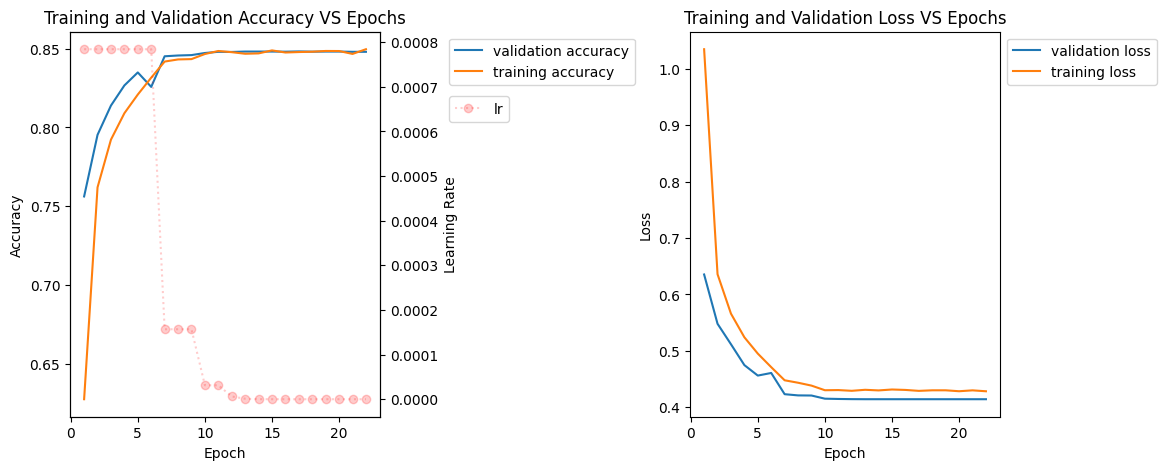



Fold# 2 metrics plot


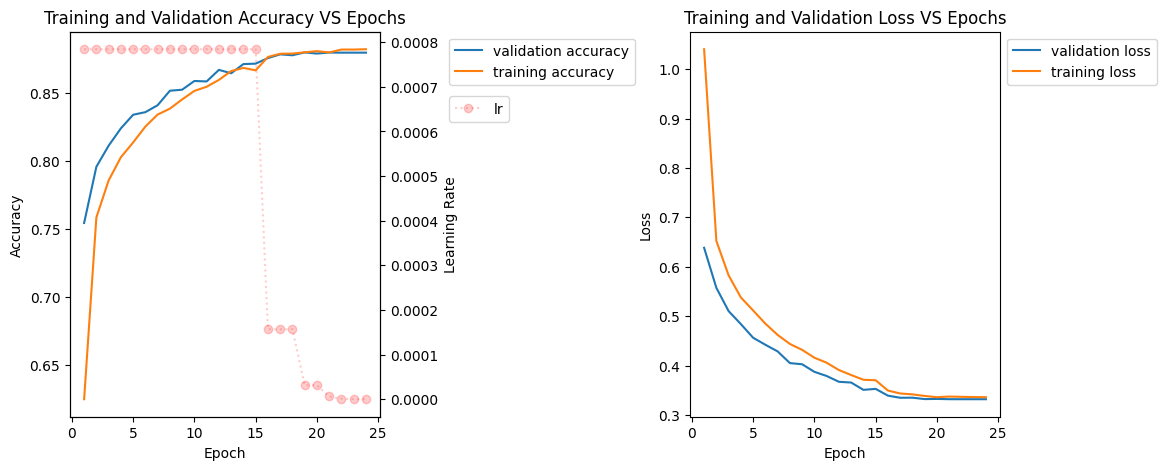



Fold# 3 metrics plot


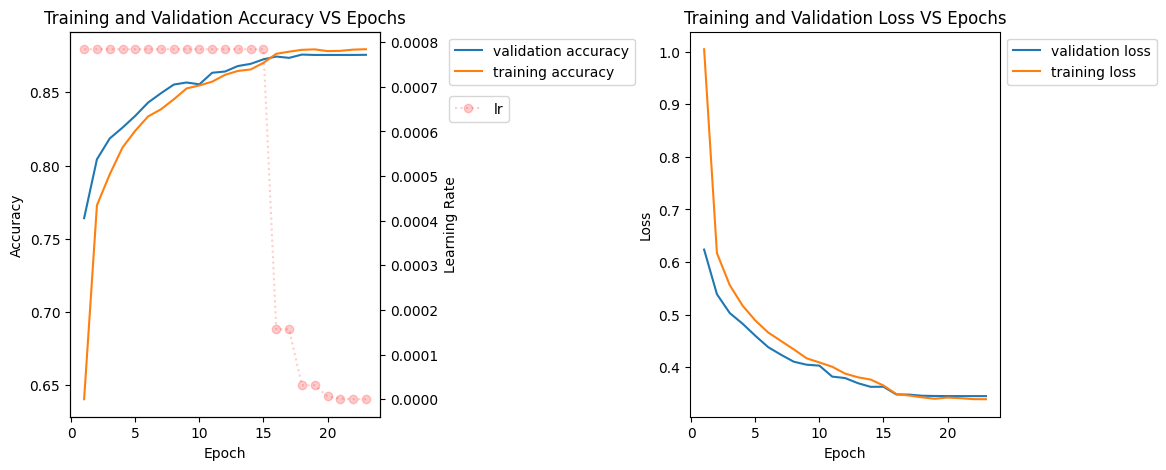



Fold# 4 metrics plot


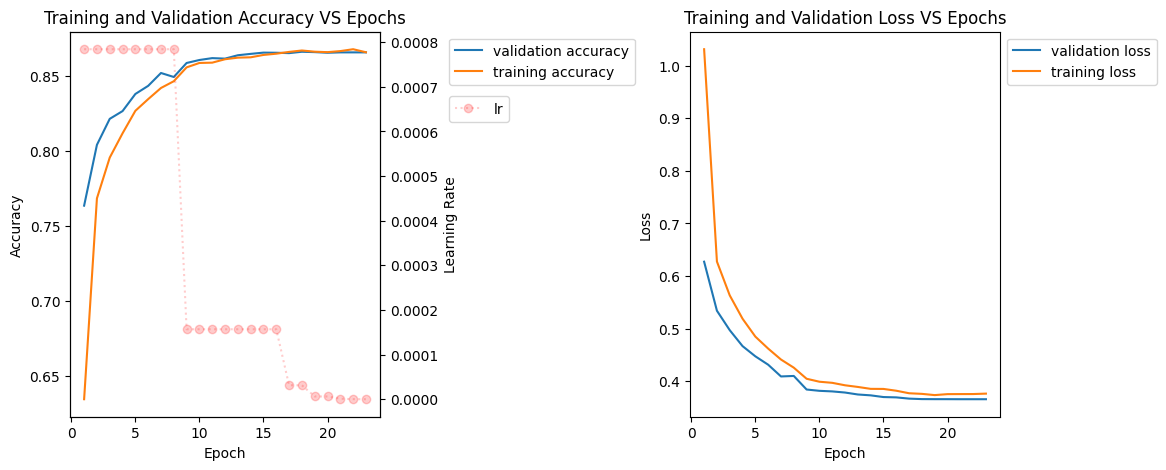



Fold# 5 metrics plot


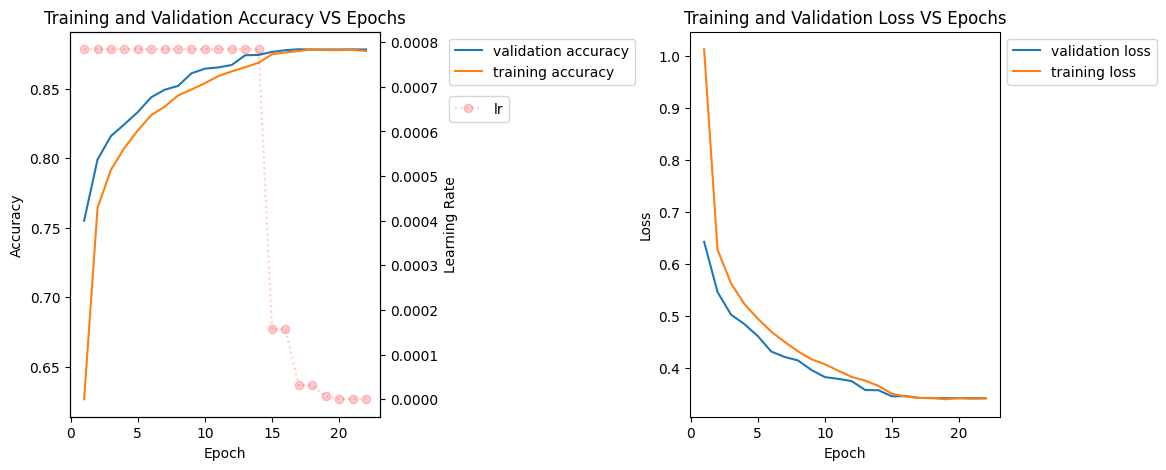

In [ ]:
# plot training and validation metrics
i =1
for history in history_per_fold:
    print(f"Fold# {i} metrics plot")
    model_history_plot(history)
    print("\n")
    i+=1

In [ ]:
history_per_fold[0].history['accuracy']

[0.6276249885559082,
 0.7620208263397217,
 0.7922916412353516,
 0.8090416789054871,
 0.8208958506584167,
 0.8316041827201843,
 0.8418124914169312,
 0.8431666493415833,
 0.843375027179718,
 0.8466041684150696,
 0.848520815372467,
 0.8477708101272583,
 0.8467708230018616,
 0.847000002861023,
 0.8488958477973938,
 0.8475624918937683,
 0.8478541374206543,
 0.8480625152587891,
 0.8485416769981384,
 0.8485000133514404,
 0.846666693687439,
 0.8496458530426025]

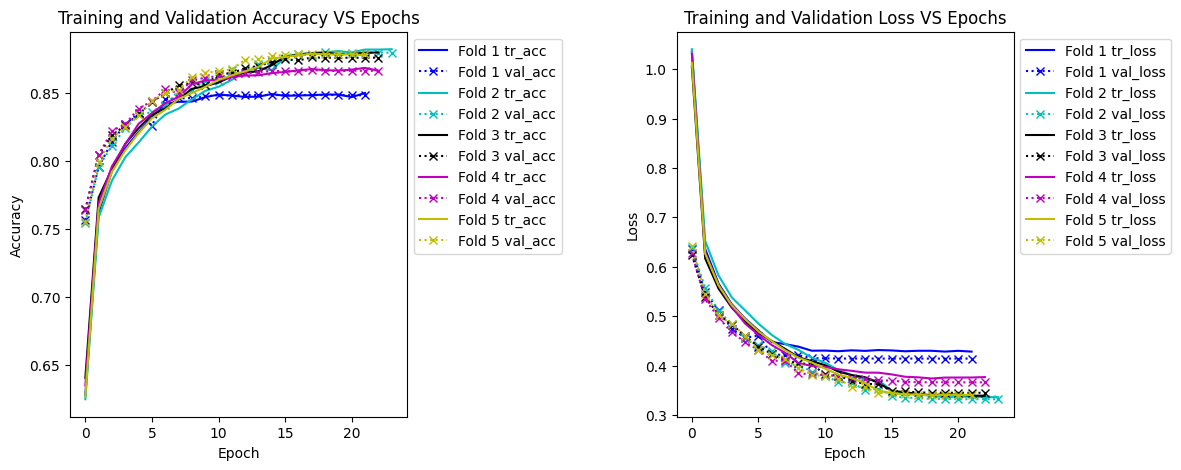

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.8)

ax2 = fig.add_subplot(131)
# Training and Validation Accuracy
for i in range(len(history_per_fold)):
    line_colour = ['b', 'c', 'k', 'm', 'y']
    plt.plot(history_per_fold[i].history['accuracy'], f"{line_colour[i]}", label=f'Fold {i+1} tr_acc')
    plt.plot(history_per_fold[i].history['val_accuracy'],f"x:{line_colour[i]}", label=f'Fold {i+1} val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy VS Epochs')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

ax1 = fig.add_subplot(132)
# Training and Validation Loss
for i in range(len(history_per_fold)):
    plt.plot(history_per_fold[i].history['loss'], f"{line_colour[i]}", label=f'Fold {i+1} tr_loss')
    plt.plot(history_per_fold[i].history['val_loss'], f"x:{line_colour[i]}",label=f'Fold {i+1} val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss VS Epochs')
plt.legend( bbox_to_anchor=(1, 1), loc="upper left")

plt.show()


# Transfer Learning

## Model 1 **InceptionV3**

Importing base model to visualize its structure

In [ ]:
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(input_shape=(299, 299, 3)) # laods the architecture without weights

# Optionally, uncomment the following line to display the full model
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In the original InceptionV3, the last layer is designed to classify among the 1,000 classes provided in ImageNet. In Fashion MNIST we only have ten classes. Therefore, we need to modify the last dense layer in the model to be able to perform classification on Fashion MNIST. Moreover, we will freeze the model and only train the new added dense layer of 10 neurons.

In [ ]:
#Load the VGG
inception_model = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3)) # laods the architecture with weights trained on imagenet dataset , include_top means get the FC layer

# Freeze all the layers
for layer in inception_model.layers[:]:
    layer.trainable = False

output = inception_model.get_layer('avg_pool').output
output = Dense(units=10, activation='softmax')(output)  # removes the last FC layer of 1000 classes and replace it with 10 neurons FC layer for our dataset classes
model = Model(inception_model.input, output)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

Now we can see that our new fully-connected layer with only ten activations is added instead of the original layer. Also, as we have frozen the weights of the model, we see that the trainable parameters of the network belong to the new dense layer only

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 model_2 (Functional)        (None, 10)                134301514 
                                                                 
Total params: 134,301,514
Trainable params: 40,970
Non-trainable params: 134,260,544
_________________________________________________________________


To avoid modifying the whole dense layer of the original InceptionV3 model in sake of faster training time we will need to resize our input image of Fashion MNIST from 28x28 to be 299x299 as the original model was designed for this size which in part will be defining the size of the flatten vector, which is just before the fully-connected layer, so if we modify the input image size to any other image resolution than 299x299 the flatten vector would inevitably need to be changed as well, which will lead us to drop the whole dense layers by setting `inlude_top = False`. So instead of dropping the whole dense layers we will be resizing our Fashion MNIST input image size and as we mentioned above we will set `include_top = True` and will just drop the last fully-connected layer and replace it with one of 10 activations.

In [ ]:
# Note that Inception model needs 3 channel image and Fashion MNIST is only 1 channel
x_tr_rept = np.repeat(x_tr, 3, axis=-1)
x_test_rept = np.repeat(x_test, 3, axis=-1)
x_val_rept = np.repeat(x_val, 3, axis=-1)

In [ ]:
print('Training set shape BEFORE repeating channels: {}'.format(x_tr.shape))
print('Training set shape AFTER repeating channels: {}'.format(x_tr_rept.shape),"\n")

print('Validation set shape BEFORE repeating channels: {}'.format(x_val.shape))
print('Validation set shape AFTER repeating channels: {}'.format(x_val_rept.shape),"\n")

print('Testing set shape BEFORE repeating channels: {}'.format(x_test.shape))
print('Testing set shape AFTER repeating channels: {}'.format(x_test_rept.shape))

Training set shape BEFORE repeating channels: (48000, 28, 28, 1)
Training set shape AFTER repeating channels: (48000, 28, 28, 3) 

Validation set shape BEFORE repeating channels: (12000, 28, 28, 1)
Validation set shape AFTER repeating channels: (12000, 28, 28, 3) 

Testing set shape BEFORE repeating channels: (10000, 28, 28, 1)
Testing set shape AFTER repeating channels: (10000, 28, 28, 3)


In [ ]:
newInput = Input(batch_shape=(None, 28, 28, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (299, 299)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

In [ ]:
model.compile(optimizer=Adam(lr=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
%%time

# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.01,
                                min_lr=1e-7)

history = model.fit(x_tr_rept, y_tr,
                    validation_data = (x_val_rept, y_val),
                    batch_size = 32,
                    epochs = 50,
                    callbacks=[earlystop_callback, lr_reduction])

Epoch 1/50
1500/1500 [==============================] - 222s 144ms/step - loss: 0.7553 - accuracy: 0.8228 - val_loss: 1.0996 - val_accuracy: 0.8062 - lr: 0.0100
Epoch 2/50
1500/1500 [==============================] - 214s 143ms/step - loss: 0.6929 - accuracy: 0.8592 - val_loss: 0.7976 - val_accuracy: 0.8392 - lr: 0.0100
Epoch 3/50
1500/1500 [==============================] - 254s 169ms/step - loss: 0.6480 - accuracy: 0.8688 - val_loss: 0.5896 - val_accuracy: 0.8794 - lr: 0.0100
Epoch 4/50
1500/1500 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.8737
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1500/1500 [==============================] - 254s 170ms/step - loss: 0.6596 - accuracy: 0.8737 - val_loss: 0.9262 - val_accuracy: 0.8594 - lr: 0.0100
Epoch 5/50
1500/1500 [==============================] - 254s 169ms/step - loss: 0.3088 - accuracy: 0.9180 - val_loss: 0.4388 - val_accuracy: 0.8949 - lr: 0.0020
Epoch 6/50
1500/1500 [==========

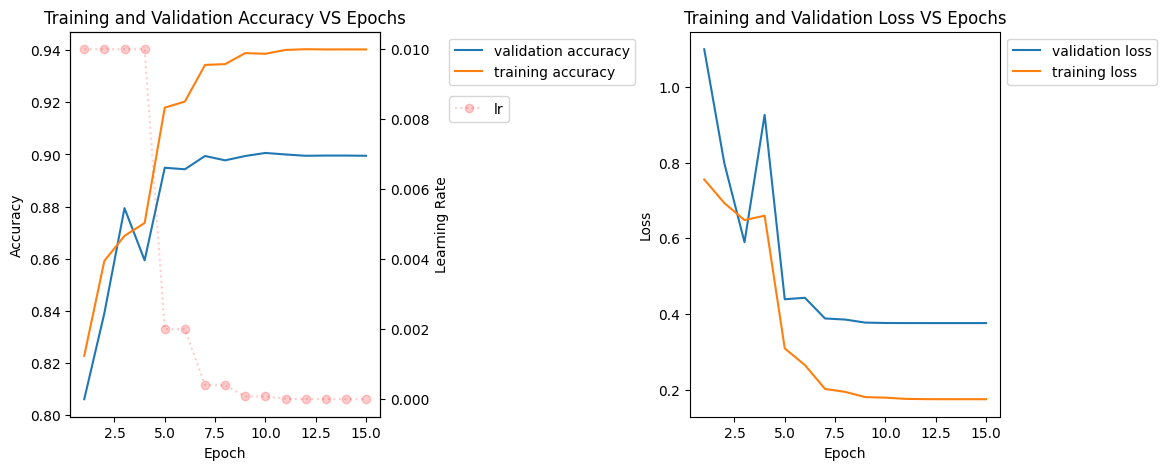

In [ ]:
model_history_plot(history)

In [ ]:
score = model.evaluate(x_test_rept, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 38s 116ms/step - loss: 0.3973 - accuracy: 0.8948
Test loss: 0.39729049801826477
Test accuracy: 0.8948000073432922


## Model 2 **MobileNet**

Importing base model to visualize its structure

In [ ]:
from keras.applications import MobileNet

model = MobileNet(input_shape=(224, 224, 3)) # laods the architecture without weights

# Optionally, uncomment the following line to display the full model
model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In the original MobileNet, the last layer is designed to classify among the 1,000 classes provided in ImageNet. In Fashion MNIST we only have ten classes. Therefore, we need to modify the last dense layer in the model to be able to perform classification on Fashion MNIST. Moreover, we will freeze the model and only train the new added dense layer of 10 neurons.

In [ ]:
#Load the MobileNet
MobileNet_model = MobileNet(weights='imagenet', include_top=True, input_shape=(224, 224, 3)) # laods the architecture with weights trained on imagenet dataset , include_top means get the FC layer

# Freeze all the layers
for layer in MobileNet_model.layers[:]:
    layer.trainable = False

output = MobileNet_model.get_layer('reshape_2').output
output = Dense(units=10, activation='softmax')(output)  # removes the last FC layer of 1000 classes and replace it with 10 neurons FC layer for our dataset classes
model = Model(MobileNet_model.input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

Now we can see that our new fully-connected layer with only ten activations is added instead of the original layer. Also, as we have frozen the weights of the model, we see that the trainable parameters of the network belong to the new dense layer only

To avoid modifying the whole dense layer of the original MobileNet model in sake of faster training time we will need to resize our input image of Fashion MNIST from 28x28 to be 224x224 as the original model was designed for this size which in part will be defining the size of the flatten vector, which is just before the fully-connected layer, so if we modify the input image size to any other image resolution than 224x224 the flatten vector would inevitably need to be changed as well, which will lead us to drop the whole dense layers by setting `inlude_top = False`. So instead of dropping the whole dense layers we will be resizing our Fashion MNIST input image size and as we mentioned above we will set `include_top = True` and will just drop the last fully-connected layer and replace it with onw of 10 activations.

In [ ]:
# Note that Inception model needs 3 channel image and Fashion MNIST is only 1 channel
x_tr_rept = np.repeat(x_tr, 3, axis=-1)
x_test_rept = np.repeat(x_test, 3, axis=-1)
x_val_rept = np.repeat(x_val, 3, axis=-1)

In [ ]:
print('Training set shape BEFORE repeating channels: {}'.format(x_tr.shape))
print('Training set shape AFTER repeating channels: {}'.format(x_tr_rept.shape),"\n")

print('Validation set shape BEFORE repeating channels: {}'.format(x_val.shape))
print('Validation set shape AFTER repeating channels: {}'.format(x_val_rept.shape),"\n")

print('Testing set shape BEFORE repeating channels: {}'.format(x_test.shape))
print('Testing set shape AFTER repeating channels: {}'.format(x_test_rept.shape))

Training set shape BEFORE repeating channels: (48000, 28, 28, 1)
Training set shape AFTER repeating channels: (48000, 28, 28, 3) 

Validation set shape BEFORE repeating channels: (12000, 28, 28, 1)
Validation set shape AFTER repeating channels: (12000, 28, 28, 3) 

Testing set shape BEFORE repeating channels: (10000, 28, 28, 1)
Testing set shape AFTER repeating channels: (10000, 28, 28, 3)


In [ ]:
newInput = Input(batch_shape=(None, 28, 28, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

In [ ]:
model.compile(optimizer=Adam(lr=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
%%time

# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                patience=1,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.01,
                                min_lr=1e-6)

history = model.fit(x_tr_rept, y_tr,
                    validation_data = (x_val_rept, y_val),
                    batch_size = 32,
                    epochs = 50,
                    callbacks=[earlystop_callback, lr_reduction])

Epoch 1/50
1500/1500 [==============================] - 76s 45ms/step - loss: 2.5261 - accuracy: 0.8142 - val_loss: 2.1859 - val_accuracy: 0.8510 - lr: 0.0100
Epoch 2/50
1499/1500 [============================>.] - ETA: 0s - loss: 2.6030 - accuracy: 0.8476
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1500/1500 [==============================] - 66s 44ms/step - loss: 2.6047 - accuracy: 0.8475 - val_loss: 2.9781 - val_accuracy: 0.8425 - lr: 0.0100
Epoch 3/50
1500/1500 [==============================] - 57s 38ms/step - loss: 1.2019 - accuracy: 0.8915 - val_loss: 1.1308 - val_accuracy: 0.8900 - lr: 0.0020
Epoch 4/50
1500/1500 [==============================] - 57s 38ms/step - loss: 0.9340 - accuracy: 0.8933 - val_loss: 1.0557 - val_accuracy: 0.8836 - lr: 0.0020
Epoch 5/50
1500/1500 [==============================] - 66s 44ms/step - loss: 0.8354 - accuracy: 0.8914 - val_loss: 1.0144 - val_accuracy: 0.8732 - lr: 0.0020
Epoch 6/50
1500/1500 [====================

In [ ]:
score = model.evaluate(x_test_rept, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 10s 32ms/step - loss: 0.8836 - accuracy: 0.8785
Test loss: 0.8836148381233215
Test accuracy: 0.8784999847412109


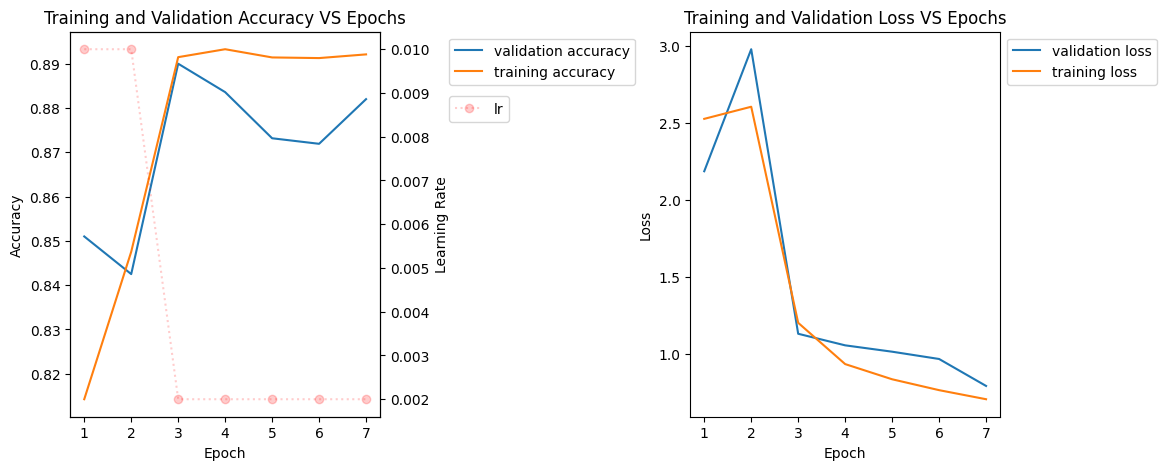

In [ ]:
model_history_plot(history)